In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time as time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, make_scorer

In [2]:
path = os.getcwd()
data = path + '/dataset/bank/bank-additional/bank-additional-full.csv'
df_orig = pd.read_csv(data, sep=';')
print(f'size of the data --> {df_orig.shape}')
df_orig.head()

size of the data --> (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# create table listing column types etc
df = df_orig.copy()        # make a copy of the data before any transformations

df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'Duplicates dropped --> {df.duplicated().sum()}')
# drop duplicates, 12 rows
df = df.drop_duplicates()
df_info

Duplicates dropped --> 12


,column,dtype,NA_count,unique_count
0,age,int64,0,78
1,job,object,0,12
2,marital,object,0,4
3,education,object,0,8
4,default,object,0,3
5,housing,object,0,3
6,loan,object,0,3
7,contact,object,0,2
8,month,object,0,10
9,day_of_week,object,0,5


### Pipeline

Use OneHotEncoder for categorical and StandardScalar for numerical variables.

In [4]:
'''pipeline for preprocessing'''
# Drop response variable from the dataframe
y = df['y']
df = df.drop('y', axis=1)
# drop duration as it is not known before a call is performed
df.drop('duration', axis=1)

# Create a pipeline for categorical features
cat_features = df.select_dtypes(include=['object']).columns
cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# df_cat= cat_pipeline.fit_transform(df[cat_features])

# Create a pipeline for numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Create a column transformer
preprocessor = ColumnTransformer([
        ('cat', cat_pipeline, cat_features),
        ('num', num_pipeline, num_features)
])

### Logistic Regression

Try logistic regression and check accuracy on test set.

In [5]:
'''Logistic Regression'''

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
])

clf.fit(X_train, y_train)
# Get the accuracy score
accuracy = clf.score(X_test, y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.9059009227780476


## Grid Search

Find the best hyperparameters for each model by conducting a grid search. Once the best model has been selected, save it so that it can be used later without training.

In [37]:
def make_model(X_train, y_train, X_test, y_test, model, param_grid, folds=5, scoring = 'roc_auc'):
    '''Function to fit a model and return the best parameters and accuracy score'''
    
    # Create a pipeline for the model
    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Create a grid search object
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    clf_grid = GridSearchCV(clf,                    # model
                       param_grid = param_grid,   # hyperparameters
                       scoring=scoring,        # metric for scoring
                       cv=cv)                     # number of folds
    
    # Fit the model
    start_time = time.time()
    clf_grid.fit(X_train,y_train)
    print("Tuned Hyperparameters :", clf_grid.best_params_)
    print("Accuracy :",clf_grid.best_score_)
    # print training time in minutes
    print('Training Time : {} minutes'.format(round((time.time() - start_time)/60,3)))
    print("Test Score :",clf_grid.score(X_test,y_test))
    
    # Get the results
    df_param = pd.DataFrame(clf_grid.cv_results_)
    
    return clf_grid, df_param

Below we define the hyperparameters we want to examine. It is important to select sensible ranges to explore as GridSearch can take quite some time depending on the number of fold. 

In [70]:
# make parameter grids
param_lr = {
    'classifier__penalty' : ['l2', 'none'], 
    'classifier__C'       : np.logspace(-5,5,5),
    'classifier__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
param_svc = {
    'classifier__C'       : [1, 10, 100],
    'classifier__kernel'  : ['linear', 'rbf', 'sigmoid'],
    'classifier__gamma'   : ['auto'],
}
param_rf = {
    'classifier__n_estimators' : [100, 200, 300],
    'classifier__max_depth'    : [10, 20, 30],
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf'  : [1, 2],
}
param_gbc = {
    'classifier__loss' : ['deviance', 'exponential'],
    'classifier__n_estimators' : [100, 200, 300],
    'classifier__max_depth' : [10, 20, 30],
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 5],
}
param_dt = {
    'classifier__max_depth' : [5, 10, 15, 20, 25],
    'classifier__min_samples_split' : [2, 5, 10, 15, 100],
    'classifier__min_samples_leaf'  : [1, 2, 5, 10, 15],
}
param_sgd = {
    'classifier__loss' : ['hinge', 'log', 'squared_hinge'],
    'classifier__penalty' : ['l2', 'l1', 'elasticnet', 'none'],
    'classifier__alpha' : [0.0001, 0.001, 0.01, 0.1, 1],
    'classifier__learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
}
param_knn = {
    'classifier__n_neighbors' : [3, 5, 7],
    'classifier__weights' : ['uniform', 'distance'],
    'classifier__algorithm' : ['auto'],
    'classifier__leaf_size' : [10, 20, 30, 40],
    'classifier__p' : [2],
}


### Logistic Regression

In [38]:
random_state = 42
folds = 5
model = LogisticRegression(random_state=random_state)
parameters = param_lr
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
clf_grid, clf_param = make_model(X_train, y_train, X_test, y_test, model, parameters, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'model_lr_{folds}.pkl', 'wb'))


Tuned Hyperparameters : {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Accuracy : 0.9362970801661934
Training Time : 1.351 minutes
Test Score : 0.9306044598235266


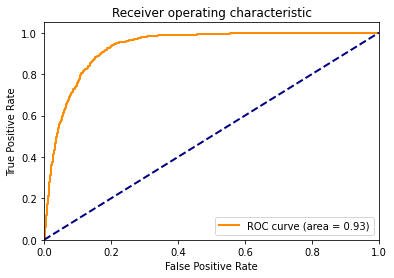

Accuracy:  0.9306044598235266


In [68]:
# load model
folds = 5
clf_grid = pickle.load(open(f'model_lr_{folds}.pkl', 'rb'))

y_score = clf_grid.decision_function(X_test)    # use decision function to get the probability scores for linear models
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy = clf_grid.score(X_test, y_test)
print('Accuracy: ', accuracy)

### Support Vector Classifier

In [42]:
random_state = 42
folds = 5
model = SVC(random_state=random_state)
parameters = param_svc
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
clf_grid, clf_param = make_model(X_train, y_train, X_test, y_test, model, parameters, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'model_svc_{folds}.pkl', 'wb'))

Tuned Hyperparameters : {'classifier__C': 100, 'classifier__gamma': 'auto', 'classifier__kernel': 'linear'}
Accuracy : 0.9343346063035536
Training Time : 75.425 minutes
Test Score : 0.9287889752584056


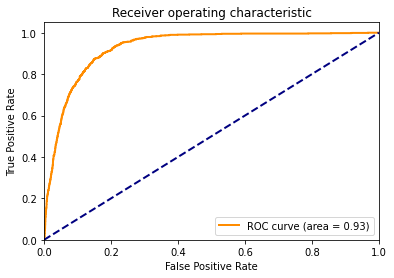

In [67]:
# load model
folds = 5
clf_grid = pickle.load(open(f'model_svc_{folds}.pkl', 'rb'))

y_score = clf_grid.decision_function(X_test)    # use decision function to get the probability scores for linear models
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy = clf_grid.score(X_test, y_test)
print('Accuracy: ', accuracy)

### Random Forest

In [44]:
random_state = 42
folds = 5
model = RandomForestClassifier(random_state=random_state)
parameters = param_rf
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
clf_grid, clf_param = make_model(X_train, y_train, X_test, y_test, model, parameters, folds=folds)


pickle.dump(clf_grid, open(f'model_rf_{folds}.pkl', 'wb'))

Tuned Hyperparameters : {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy : 0.9445766645181829
Training Time : 13.498 minutes
Test Score : 0.941452288422051


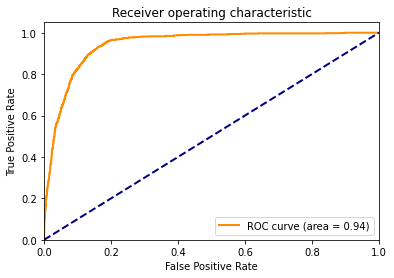

In [66]:
# load model
folds = 5
clf_grid = pickle.load(open(f'model_rf_{folds}.pkl', 'rb'))

# Convert string labels to binary values
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_prob = clf_grid.predict_proba(X_test)[:, 1]   # use predict_proba to get the probability scores for non-linear models
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy = clf_grid.score(X_test, y_test)
print('Accuracy: ', accuracy)

### Gradient Boosting Classifier

In [71]:
random_state = 42
folds = 5
model = GradientBoostingClassifier(random_state=random_state)
parameters = param_gbc
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
clf_grid, clf_param = make_model(X_train, y_train, X_test, y_test, model, parameters, folds=folds)


pickle.dump(clf_grid, open(f'model_rf_{folds}.pkl', 'wb'))

In [ ]:
# load model
folds = 5
clf_grid = pickle.load(open(f'model_sgd_{folds}.pkl', 'rb'))

y_score = clf_grid.decision_function(X_test)        # use decision function to get the probability scores for linear models
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy = clf_grid.score(X_test, y_test)
print('Accuracy: ', accuracy)

### Decision Tree

In [ ]:
random_state = 42
folds = 5
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_dt
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
clf_grid, clf_param = make_model(X_train, y_train, X_test, y_test, model, parameters, folds=folds)


pickle.dump(clf_grid, open(f'model_dt_{folds}.pkl', 'wb'))

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 100}
Accuracy : 0.9321894989752376
Training Time : 1.688 minutes
Test Accuracy : 0.9336759132530941


### Stochastic Gradient Decsent Classifier

In [ ]:
random_state = 42
folds = 5
model = SGDClassifier(random_state=random_state)
parameters = param_sgd
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
clf_grid, clf_param = make_model(X_train, y_train, X_test, y_test, model, parameters, folds=folds)


pickle.dump(clf_grid, open(f'model_sgd_{folds}.pkl', 'wb'))

Tuned Hyperparameters : {'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'log', 'classifier__penalty': 'none'}
Accuracy : 0.9358794670826871
Training Time : 6.103 minutes
Test Score : 0.9286337511154521


### K-Nearest Neighbours Classifier

In [35]:
random_state = 42
folds = 5
model = KNeighborsClassifier()
parameters = param_knn
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
clf_grid, clf_param = make_model(X_train, y_train, X_test, y_test, model, parameters, folds=folds)


pickle.dump(clf_grid, open(f'model_knn_{folds}.pkl', 'wb'))

Tuned Hyperparameters : {'classifier__algorithm': 'auto', 'classifier__leaf_size': 10, 'classifier__n_neighbors': 11, 'classifier__p': 2, 'classifier__weights': 'distance'}
Accuracy : 0.9068433578052135
Training Time : 40.134 minutes
Test Score : 0.9007684658255266



When to Use Accuracy?
 

Accuracy is used for balanced datasets i.e. when the classes are equally distributed. 

A real-life example is fraud detection which must correctly identify and distinguish fraudulent transactions (class of interest) from regular transactions. Usually, fraudulent transactions are rare i.e. their occurrence in the training data set would be less than ~1%.

Accuracy in this case would be a biased representation of model performance and would declare the model good even if it identifies every transaction as non-fraudulent. Such a model would have high accuracy but fails to predict any fraudulent transaction, defeating the purpose of building the model. 

 

When to Use AUC?
 

AUC is well-suited for imbalanced datasets. For example, the fraud detection model must correctly identify fraud even if it comes at the cost of flagging some (a small number) of the non-fraudulent transactions as fraudulent.

It is highly probable that while focusing on correctly identifying the class of interest (fraudulent transactions) i.e. the TPs, the model makes some mistakes i.e. FPs (marking non-fraudulent transactions as fraudulent). Thus it’s important to look at a measure that compares TPR and FPR. This is where AUC fits in.